In [1]:
import pandas as pd

In [2]:
def tidy_decimal(decimal, places):
    # https://stackoverflow.com/a/60962766
    # trim a decimal value to a certain number of places without trailing 0s and, if a whole number, without decimal point
    return f"{decimal:.{places}f}".rstrip('0').rstrip('.')

In [3]:
def mean(lst):
    # statistics.mean does not play nicely with the list of flows
    return sum(lst)/len(lst)

Data is in an Excel sheet, structured like so:
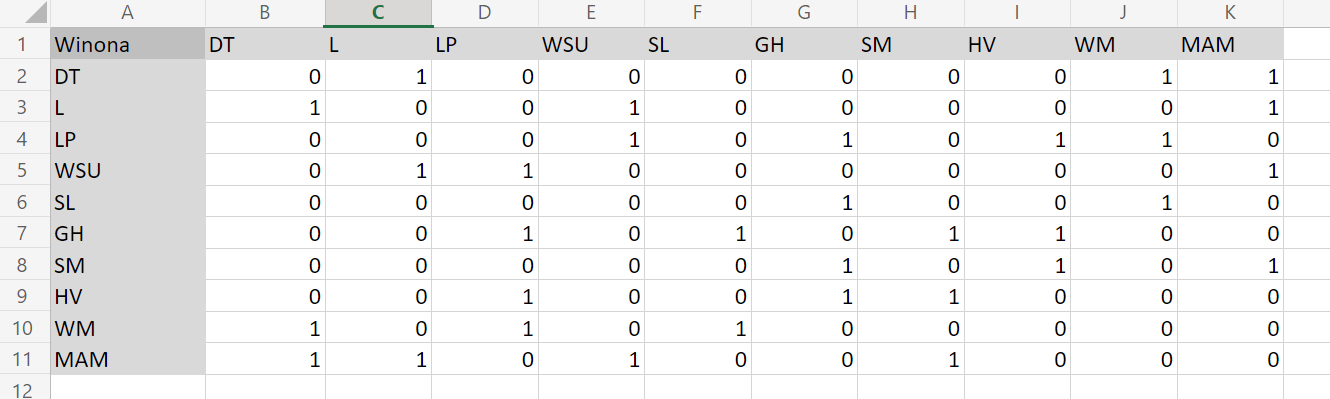

The different towns are on different sheets in the file, like so:
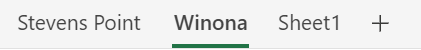

In [4]:
# load in data
# index_col = 0 tells it to use column A as indexes instead of as actual data
# We had some extra calculations on the sheet, so nrows was used to trim it to just the matrix
#    - a clean sheet could probably go without it. 10 is the number of points we had.
winona = pd.read_excel("MATH322BIKEPROJECT.xlsx", sheet_name="Winona", index_col=0, nrows=10)
stevens_point = pd.read_excel("MATH322BIKEPROJECT.xlsx", sheet_name="Stevens Point", index_col=0, nrows=10)

In [5]:
winona # preview to check it imported correctly

,DT,L,LP,WSU,SL,GH,SM,HV,WM,MAM
Winona,,,,,,,,,,
DT,0,1,0,0,0,0,0,0,1,1
L,1,0,0,1,0,0,0,0,0,1
LP,0,0,0,1,0,1,0,1,1,0
WSU,0,1,1,0,0,0,0,0,0,1
SL,0,0,0,0,0,1,0,0,1,0
GH,0,0,1,0,1,0,1,1,0,0
SM,0,0,0,0,0,1,0,1,0,1
HV,0,0,1,0,0,1,1,0,0,0
WM,1,0,1,0,1,0,0,0,0,0


In [6]:
stevens_point

,BP,L/DT,SPS,DP,UWSP,SR,OG,BT,CC/T,WM
Steven's Point,,,,,,,,,,
BP,0,1,1,0,1,0,0,0,0,0
L/DT,1,0,1,1,1,0,1,0,0,0
SPS,1,1,0,0,0,1,0,0,0,0
DP,0,1,0,0,0,0,1,0,0,0
UWSP,1,1,0,0,0,1,1,1,0,0
SR,0,0,1,0,1,0,0,1,0,0
OG,0,1,0,1,1,0,0,1,1,1
BT,0,0,0,0,1,1,1,0,0,0
CC/T,0,0,0,0,0,0,1,0,0,0


In [7]:
# https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/, modified for a pandas DataFrame instead of list of lists

class Graph:
 
    def __init__(self, graph):
        self.graph = graph
        self.ROW = len(graph) # number of rows
 
    def bfs_reachable(self, s, t, parent): # from the link, lightly modified
        
        '''Returns true if there is a path from source 's' to sink 't' in
        residual graph. Also fills parent[] to store the path. Used with FordFulkerson '''
 
        # Mark all the vertices as not visited
        visited = [False]*(self.ROW)
 
        # Create a queue for BFS
        queue = []
 
        # Mark the source node as visited and enqueue it
        queue.append(s)
        visited[s] = True
 
         # Standard BFS Loop
        while queue:
 
            # Dequeue a vertex from queue and print it
            u = queue.pop(0)
 
            # Get all adjacent vertices of the dequeued vertex u
            # If a adjacent has not been visited, then mark it visited and enqueue it
            for idx, val in enumerate(self.graph.iloc[u]): # get the row of connected values
                if visited[idx] == False and val > 0:
                    # If we find a connection to the sink node, then there is no point in BFS anymore
                    # We just have to set its parent and can return true
                    queue.append(idx)
                    visited[idx] = True # mark node as checked so we don't get into infinite loops
                    parent[idx] = u # where was this connected from
                    if idx == t:
                        return True
 
        # We didn't reach sink in BFS starting from source, so return false
        return False
    
    def FordFulkerson(self, source, sink):
        
        '''
        1) Start with initial flow as 0.
        2) While there is a augmenting path from source to sink, add this path-flow to flow.
        3) Return flow.
        '''
 
        # This array is filled by BFS and to store path
        parent = [-1]*(self.ROW)
 
        max_flow = 0 # There is no flow initially
 
        # Augment the flow while there is path from source to sink
        while self.bfs_reachable(source, sink, parent) :
 
            # Find minimum residual capacity of the edges along the path filled by BFS. 
            # Or we can say find the maximum flow through the path found.
            path_flow = float("Inf")
            s = sink
            while(s !=  source):
                path_flow = min(path_flow, self.graph.iloc[parent[s]][s])
                s = parent[s]
 
            # Add path flow to overall flow
            max_flow += path_flow
 
            # update residual capacities of the edges and reverse edges along the path
            v = sink
            while(v !=  source):
                u = parent[v]
                self.graph.iloc[u][v] -= path_flow
                self.graph.iloc[v][u] += path_flow
                v = parent[v]
 
        return max_flow

    def bfs(self, start, end): # I wrote this one, based on the above version
        
        # A version of the BFS algorithm above, modified to return the BFS distance
        # How many edges does it take to get from node start to node end?
        # Returns -1 if they are not connected
        
        visited = [False] * self.ROW # all nodes are initially unvisited
        queue = [start]
        distance = 0
        visited[start] = True
        children = []
        
        while len(queue) > 0:
            vertex = queue.pop(0) # index of the vertex or a list of the next level down of connections
            if vertex == end:
                return distance
            
            # Haven't found it yet, add the connected nodes to the queue
            
            for idx, val in enumerate(self.graph.iloc[vertex]): # get the row
                if val and not visited[idx]: # connected vertex that has not yet been checked
                    children.append(idx)
                    visited[idx] = True # mark it as visited (or will visit) so we don't get dupes
            
            if len(queue) == 0: # we are out of nodes at this distance to examine
                distance += 1
                queue = children.copy() # take the list of nodes at the next level and make it just the items
                children.clear()
        
        # we have checked everything and couldn't reach it - maybe node is disconnected?
        return -1

In [8]:
def analysis(df):
    
    # Does all graph analysis, printing report
    # Probably not the best practice, but the degree analysis is the only part that can really be isolated anyways
    
    # Mean degree
    
    df["degree"] = df.sum(axis=1) # compute degree by summing rows
    print("Most connected nodes (max degree):")
    print (", ".join(df[df.degree == df.degree.max()].index), " - ", df.degree.max())
    print("Least connected nodes (min degree):")
    print (", ".join(df[df.degree == df.degree.min()].index), " - ", df.degree.min())
    mean_degree = df.degree.mean()
    print("Mean degree of graph: ", tidy_decimal(mean_degree, 3))
    
    df.drop("degree", axis="columns", inplace=True) # remove field now that we're done, messes up other calcs if kept
    
    # Calculate distances and max flows for the points
    # These lists will contain n(n-1)/2 values, where n = number of vertices
    
    distances = []
    flows = []

    for i in range(df.shape[0]): # number of rows
        for j in range(df.shape[1]): # number of columns
            if i == j: # don't double count a pair or do a pair connected with itself
                break        
            graph = Graph(df.copy()) # the method messes with the matrix, so it must recreated every time
            distances.append(graph.bfs(i,j))
            flows.append(graph.FordFulkerson(i,j))
    
    model_weights = [0.5, 0.4, 0.1] # mean degree, mean max flow, mean distance
 
    mean_max_flow = mean(flows)
    print(f"Mean max flow/Mean local edge connectivity: {sum(flows)}/{len(flows)} = {tidy_decimal(mean_max_flow, 3)}")
    print("Edge connectivity: ", min(flows))
    
    # Filter out bad distances
    if any([d == -1 for d in distances]):
        print("At least one vertex disconnected. Distances involving the vertex will be dropped.")
    if any([d == 0 for d in distances]):
        print("At least one self-referential vertex distance was calculated. These distances wil be dropped.")
    distances = [d for d in distances if d >= 1]
    
    mean_distance = mean(distances)
    print(f"Mean distance: {sum(distances)}/{len(distances)} = {tidy_decimal(mean_distance, 3)}")
    
    overall = model_weights[0]*mean_degree + model_weights[1] * mean_max_flow + model_weights[2] / mean_distance
    print(f"Overall connectivity (using weights {model_weights}): {tidy_decimal(overall,3)}\n")

In [9]:
print("Analysis for Winona:")
analysis(winona)
print("Analysis for Stevens Point:")
analysis(stevens_point)

Analysis for Winona:
Most connected nodes (max degree):
LP, GH, MAM  -  4
Least connected nodes (min degree):
SL  -  2
Mean degree of graph:  3.2
Mean max flow/Mean local edge connectivity: 127/45 = 2.822
Edge connectivity:  2
Mean distance: 82/45 = 1.822
Overall connectivity (using weights [0.5, 0.4, 0.1]): 2.784

Analysis for Stevens Point:
Most connected nodes (max degree):
OG  -  6
Least connected nodes (min degree):
CC/T, WM  -  1
Mean degree of graph:  3.2
Mean max flow/Mean local edge connectivity: 98/45 = 2.178
Edge connectivity:  1
Mean distance: 81/45 = 1.8
Overall connectivity (using weights [0.5, 0.4, 0.1]): 2.527

